# Weather Prediction

## 🌤️ Project Overview

We will use machine learning to predict the weather using historical data.Our goal is to make predictions for the next day's weather.

The dataset focuses on San Antonio, Texas, and comes from the National Centers for Environmental Information (NCEI). You can retrieve the original data from the Climate Data Online Search (NCEI) available at  
https://www.ncei.noaa.gov/cdo-web/search. We selected daily summaries for the period from January 1, 1960 through June 10, 2023,   using data from the San Antonio International Airport station.

In [295]:
import pandas as pd
import numpy as np

## Read the data into a pandas dataframe

In [296]:
weather = pd.read_csv('local_weather.csv', index_col='DATE')

In [297]:
weather.head()

,STATION,NAME,ACMH,ACSH,AWND,DAPR,FMTM,FRGT,MDPR,PGTM,...,WT01,WT02,WT03,WT04,WT05,WT07,WT08,WT09,WT16,WT18
DATE,,,,,,,,,,,,,,,,,,,,,
1960-01-01,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-02,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1960-01-03,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-04,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-05,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


We have 23,172 days of weather data and 47 columns providing some attribute of the weather on those days.  Before we identify what attribute these columns are describing, we will first look at the amount of data they contain to whittle down to the ones that will help us with our predictions. 

## Preparing the data for machine learning

### We want to identify columns with enough data.

In [298]:
weather.apply(pd.isnull).sum()/weather.shape[0]

STATION    0.000000
NAME       0.000000
ACMH       0.653360
ACSH       0.653360
AWND       0.522451
DAPR       0.999525
FMTM       0.870099
FRGT       0.999881
MDPR       0.999525
PGTM       0.495106
PRCP       0.016668
SNOW       0.324990
SNWD       0.317634
TAVG       0.879174
TMAX       0.000534
TMIN       0.000593
TSUN       0.931728
WDF1       0.653360
WDF2       0.522392
WDF5       0.527552
WDFG       0.746901
WSF1       0.653360
WSF2       0.522332
WSF5       0.527552
WSFG       0.746901
WT01       0.779939
WT02       0.980248
WT03       0.992941
WT04       0.999763
WT05       0.998339
WT07       0.999881
WT08       0.810368
WT09       0.999881
WT16       0.884038
WT18       0.999822
dtype: float64

### Handling Missing Data

The numbers above represent the proportion of missing data in each column.  
A higher number indicates that the column has more missing values and therefore provides less useful data.

This dataset has five core features:

- `PRCP` — Precipitation  
- `SNOW` — Snowfall  
- `SNWD` — Snow


In [299]:
core_weather = weather [['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN']].copy()

Now that we are down to five columns, let's identify what they measure and in what units.


`PRCP` = Precipitation (inches to hundredths) 

`SNOW` = Snowfall (inches to tenths)

`SNWD` = Snow depth (inches)

`TMAX` = Maximum temperature (Fahrenheit to tenths)

`TMIN` = Minimum temperature (Fahrenheit to tenths)


Next, we will rename the columns to be more intuitive.

In [300]:
core_weather.columns = ['precip', 'snow', 'snow_depth', 'temp_max', 'temp_min']
core_weather

,precip,snow,snow_depth,temp_max,temp_min
DATE,,,,,
1960-01-01,0.0,0.0,0.0,49.0,30.0
1960-01-02,0.0,0.0,0.0,49.0,29.0
1960-01-03,0.0,0.0,0.0,54.0,35.0
1960-01-04,0.0,0.0,0.0,54.0,36.0
1960-01-05,0.0,0.0,0.0,55.0,33.0
...,...,...,...,...,...
2022-01-24,0.0,NaN,NaN,60.0,39.0
2022-01-25,0.0,NaN,NaN,57.0,43.0
2022-01-26,0.0,NaN,NaN,57.0,41.0


### Handling any remaining missing values

In [301]:
core_weather.apply(pd.isnull).sum()/core_weather.shape[0]

precip        0.016668
snow          0.324990
snow_depth    0.317634
temp_max      0.000534
temp_min      0.000593
dtype: float64

The `snow` and `snow_depth` columns have the most missing values.  We will look at the `snow` column first.

In [302]:
core_weather['snow'].value_counts()

snow
0.0    11379
1.0        1
Name: count, dtype: int64

The values on the left represent inches of snow, and there are less than thirty days out of over 21,000 where there was any measureable snow.  Hence, this column will not provide our model with much data to use.  So, we are not going to use this column.

In [303]:
del core_weather['snow']

Now, let's take a look at `snow_depth`.

In [304]:
core_weather['snow_depth'].value_counts()

snow_depth
0.0    11504
Name: count, dtype: int64

If there are not many days of snow, then there will also not be much data on snow depth.  The data above shows there's even less data here; so, we will not use this column either.

In [305]:
del core_weather['snow_depth']

Next, we will take a look at the few missing values in `temp_max`.

In [306]:
core_weather['temp_max'].isnull().sum()

9

There are only two days out of over 23,000 that we do not have data for.  We will take a look at those values.

In [307]:
core_weather[pd.isnull(core_weather['temp_max'])]

,precip,temp_max,temp_min
DATE,,,
2004-11-20,NaN,NaN,NaN
2013-06-16,0.0,NaN,NaN
2019-04-18,0.0,NaN,50.0
2019-04-21,0.0,NaN,52.0
2019-04-22,0.0,NaN,50.0
2020-08-29,0.0,NaN,NaN
2020-09-08,0.0,NaN,NaN
2020-09-09,0.0,NaN,NaN
2021-10-31,0.0,NaN,56.0


There's not really a way to tell what happened here.  There are a few different ways to handle this.  We could take a ten day average or mode, for example.  To use data as close to the days in question, we'll use the previous day's temperature for both days.  Because the previous day is closest to the days in question, hopefully, the temperature is close too.

In [308]:
core_weather['temp_max'] = core_weather['temp_max'].ffill()
core_weather['temp_min'] = core_weather['temp_min'].ffill()
core_weather['precip'] = core_weather['precip'].ffill()

In [309]:
core_weather.apply(pd.isnull).sum()/core_weather.shape[0]

precip      0.0
temp_max    0.0
temp_min    0.0
dtype: float64

### Verifying that we have the correct Data Types

Precipitation is in inches and both of the temperatures are in degrees Fahrenheit.  Therefore, decimal or integer will work.

In [310]:
core_weather.dtypes

precip      float64
temp_max    float64
temp_min    float64
dtype: object

In [311]:
core_weather.index

Index(['1960-01-01', '1960-01-02', '1960-01-03', '1960-01-04', '1960-01-05',
       '1960-01-06', '1960-01-07', '1960-01-08', '1960-01-09', '1960-01-10',
       ...
       '2022-01-19', '2022-01-20', '2022-01-21', '2022-01-22', '2022-01-23',
       '2022-01-24', '2022-01-25', '2022-01-26', '2022-01-27', '2022-01-28'],
      dtype='object', name='DATE', length=16859)

When importing, we used the `DATE` column as the index to make this a time-series data set.  The index are strings; so, we will convert them to a datetime object.

The date column is converted to a DatetimeIndex to enable powerful time-series analysis capabilities in pandas.

In [312]:
core_weather.index = pd.to_datetime(core_weather.index)
core_weather.index

DatetimeIndex(['1960-01-01', '1960-01-02', '1960-01-03', '1960-01-04',
               '1960-01-05', '1960-01-06', '1960-01-07', '1960-01-08',
               '1960-01-09', '1960-01-10',
               ...
               '2022-01-19', '2022-01-20', '2022-01-21', '2022-01-22',
               '2022-01-23', '2022-01-24', '2022-01-25', '2022-01-26',
               '2022-01-27', '2022-01-28'],
              dtype='datetime64[ns]', name='DATE', length=16859, freq=None)

### Analyzing our Weather data

Let's take a look at our columns plotted.

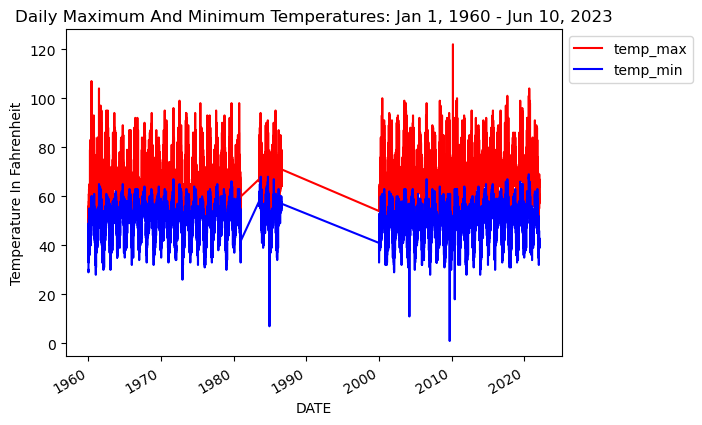

In [313]:
title = 'Daily Maximum and Minimum Temperatures: Jan 1, 1960 - Jun 10, 2023'.title()
ylabel = 'Temperature in Fahrenheit'.title()
colors = ['red', 'blue']

core_weather[['temp_max', 'temp_min']].plot(title=title, ylabel=ylabel, color=colors).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: title={'center': 'Daily Precipitation: Jan 1, 1960 - Jun 10, 2023'}, xlabel='DATE', ylabel='Precipitation In Inches'>

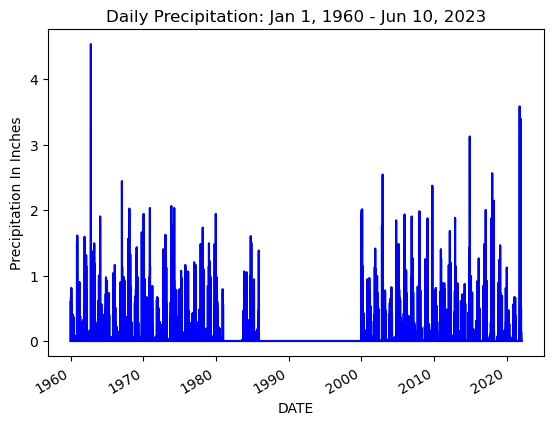

In [314]:
core_weather['precip'].plot(ylabel='Precipitation in inches')

title = 'Daily Precipitation: Jan 1, 1960 - Jun 10, 2023'.title()
ylabel = 'Precipitation in inches'.title()
color = 'blue'

core_weather['precip'].plot(title=title, ylabel=ylabel, color=color)

Our temperature columns look good; however, our precipitation shows three outliers.  Did it really rain 9 or 10 inches in one day.  We could look at those dates at a nearby weather station to verify.  Considering that it's only three data points, it should not have a big effect on our predictions.

## Remove Outliers

In [315]:
core_weather['precip'].describe()

count    16859.000000
mean         0.047317
std          0.186209
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.530000
Name: precip, dtype: float64

In [316]:
precip = np.array(core_weather['precip'])
pre, cts = np.unique(precip, return_counts=True)

In [317]:
precip_dict = dict(zip(pre, cts))
precip_dict

{0.0: 13930,
 0.01: 440,
 0.02: 200,
 0.03: 122,
 0.04: 102,
 0.05: 98,
 0.06: 85,
 0.07: 76,
 0.08: 71,
 0.09: 57,
 0.1: 71,
 0.11: 50,
 0.12: 44,
 0.13: 57,
 0.14: 61,
 0.15: 46,
 0.16: 40,
 0.17: 34,
 0.18: 52,
 0.19: 44,
 0.2: 44,
 0.21: 23,
 0.22: 37,
 0.23: 32,
 0.24: 28,
 0.25: 25,
 0.26: 32,
 0.27: 20,
 0.28: 30,
 0.29: 29,
 0.3: 26,
 0.31: 20,
 0.32: 20,
 0.33: 17,
 0.34: 17,
 0.35: 19,
 0.36: 19,
 0.37: 10,
 0.38: 17,
 0.39: 17,
 0.4: 21,
 0.41: 15,
 0.42: 11,
 0.43: 12,
 0.44: 14,
 0.45: 20,
 0.46: 15,
 0.47: 15,
 0.48: 19,
 0.49: 13,
 0.5: 21,
 0.51: 19,
 0.52: 18,
 0.53: 18,
 0.54: 10,
 0.55: 9,
 0.56: 12,
 0.57: 9,
 0.58: 12,
 0.59: 6,
 0.6: 10,
 0.61: 8,
 0.62: 10,
 0.63: 10,
 0.64: 6,
 0.65: 6,
 0.66: 19,
 0.67: 13,
 0.68: 9,
 0.69: 7,
 0.7: 7,
 0.71: 6,
 0.72: 11,
 0.73: 9,
 0.74: 11,
 0.75: 7,
 0.76: 6,
 0.77: 4,
 0.78: 5,
 0.79: 7,
 0.8: 5,
 0.81: 6,
 0.82: 4,
 0.83: 5,
 0.84: 7,
 0.85: 5,
 0.86: 4,
 0.87: 4,
 0.88: 7,
 0.89: 9,
 0.9: 4,
 0.91: 3,
 0.92: 8,
 0.94: 3,

In [318]:
core_weather = core_weather[core_weather['precip'] < 3.58]

<Axes: title={'center': 'Daily Precipitation: Jan 1, 1960 - Jun 10, 2023'}, xlabel='DATE', ylabel='Precipitation In Inches'>

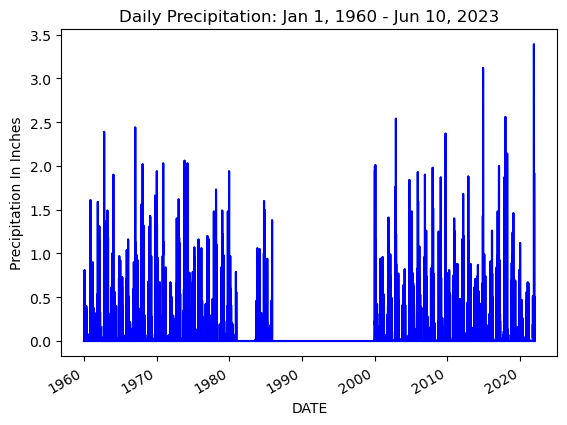

In [319]:
core_weather['precip'].plot(ylabel='Precipitation in inches')

title = 'Daily Precipitation: Jan 1, 1960 - Jun 10, 2023'.title()
ylabel = 'Precipitation in inches'.title()
color = 'blue'

core_weather['precip'].plot(title=title, ylabel=ylabel, color=color)

## Training our first machine learning model

We will be predicting the next day's maximum temperature.  `target` is temp_max for the next day.

In [320]:
core_weather['target'] = core_weather['temp_max'].shift(-1)
core_weather

/var/folders/47/54hqgdjs3tn7cpbbyqjgl_hr0000gn/T/ipykernel_30565/2439787155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  core_weather['target'] = core_weather['temp_max'].shift(-1)


,precip,temp_max,temp_min,target
DATE,,,,
1960-01-01,0.0,49.0,30.0,49.0
1960-01-02,0.0,49.0,29.0,54.0
1960-01-03,0.0,54.0,35.0,54.0
1960-01-04,0.0,54.0,36.0,55.0
1960-01-05,0.0,55.0,33.0,53.0
...,...,...,...,...
2022-01-24,0.0,60.0,39.0,57.0
2022-01-25,0.0,57.0,43.0,57.0
2022-01-26,0.0,57.0,41.0,67.0


Shifting the maximum temperature up one day created a missing value at `2023-06-10`.  We will delete the last row to eliminate this missing value.

[:-1] is standard Python slicing syntax. When applied to rows (the first dimension), it means: "Start from the beginning of the index (:) and go up to, but not including, the last position (-1)". This effectively selects all rows except the final one.

In [321]:
core_weather = core_weather.iloc[:-1].copy()
core_weather

,precip,temp_max,temp_min,target
DATE,,,,
1960-01-01,0.0,49.0,30.0,49.0
1960-01-02,0.0,49.0,29.0,54.0
1960-01-03,0.0,54.0,35.0,54.0
1960-01-04,0.0,54.0,36.0,55.0
1960-01-05,0.0,55.0,33.0,53.0
...,...,...,...,...
2022-01-23,0.0,60.0,41.0,60.0
2022-01-24,0.0,60.0,39.0,57.0
2022-01-25,0.0,57.0,43.0,57.0


We will use a Ridge Regression model because it is particularly suited when independent variables experience collinearity, when one feature can be predicted using other features.  In addition, we initialized the model with an alpha parameter that penalizes coefficients to minimize overfitting.

In [322]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=0.1)

Now, we will identify what columns we will use to make our predictions.

In [323]:
predictors = ['precip', 'temp_max', 'temp_min']

Create train and test data.

In [324]:
train = core_weather.loc[:'2021-01-10']
test = core_weather.loc['2021-01-11':]

In [325]:
train.isnull().sum()

precip      0
temp_max    0
temp_min    0
target      0
dtype: int64

Train the model.

In [326]:
reg.fit(train[predictors], train['target'])

Ridge(alpha=0.1)

Using our trained model, we will predict the `target` values in out test set.

In [327]:
predictions = reg.predict(test[predictors])

Check to see how well we did.

In [328]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(test['target'], predictions)

3.4448390307874996

## Fine tune hyperparameters using GridSearchCV

In [329]:
from sklearn.model_selection import GridSearchCV

ridge = Ridge()
alphas = np.logspace(-3, 2, 30)
param_grid = {
    'alpha': alphas,
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga']
}

grid = GridSearchCV(
    ridge,
    param_grid,
    scoring='neg_mean_absolute_error',  # tracking MAE
    cv=5,
    n_jobs=-1
)

grid.fit(train[predictors], train['target'])

print("Best params:", grid.best_params_)
print("Best MAE:", -grid.best_score_)

Best params: {'alpha': 67.23357536499334, 'fit_intercept': True, 'solver': 'saga'}
Best MAE: 3.4646416394378385


In [330]:
best_model = grid.best_estimator_
y_pred = best_model.predict(test[predictors])
mae = mean_absolute_error(test['target'], y_pred)
print(mae)

3.446229210788074


In [331]:
reg = best_model

### After fine tuning, the best model is used for the following steps.

## Evaluating Our Model

Here, we combine both our actual values and predictions to be able to see them both side-by-side.  This allows a visual inspection comparing the two and, more importantly because of the amount of days in our data set, will allow us to plot our predictions against the actual values.  Here, we look for trends that can help identify how we can improve the model.

In [332]:
combined = pd.concat([test['target'], pd.Series(predictions, index=test.index)], axis=1)
combined.columns = ['actual', 'predictions']
combined

,actual,predictions
DATE,,
2021-01-11,62.0,60.711059
2021-01-12,66.0,62.512394
2021-01-13,71.0,65.393913
2021-01-14,67.0,68.995812
2021-01-15,71.0,65.573815
...,...,...
2022-01-23,60.0,59.990680
2022-01-24,57.0,59.630361
2022-01-25,57.0,58.189859


Plot the values to get a sense of the differences.

<Axes: title={'center': 'Actual And Predicted Temperatures: Jan 1, 2021 - Jun 9, 2023'}, xlabel='DATE', ylabel='Temperature In Fahrenheit'>

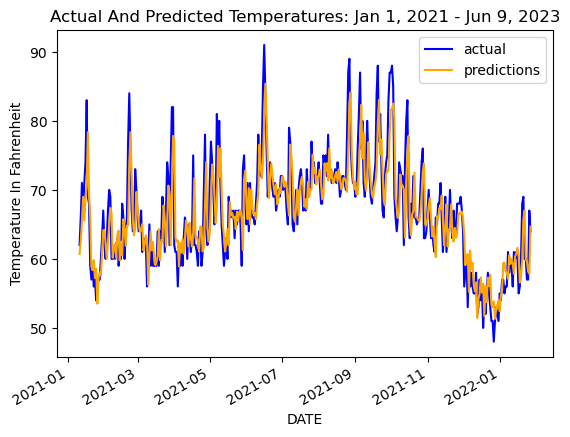

In [333]:
title = 'Actual and Predicted Temperatures: Jan 1, 2021 - Jun 9, 2023'.title()
ylabel = 'Temperature in Fahrenheit'.title()
colors = ['blue', 'orange']

combined.plot(title=title, ylabel=ylabel, color=colors)

The biggest difference is our predictions don't get as cold as the real world, in particular, and are conservative,more generally, compared to the real world.  Next, we will look at the coefficients to see what effect our variables are having on our predictions.

In [334]:
reg.coef_

array([-2.03541341,  0.72236575,  0.17875066])

Our coefficients above are in the order of our predictors: `precip`, `temp_max`, `temp_min`.  They indicate that when we have precipitation the next day will be cooler; and if today is hot, the next day will most likely be hot.  `temp_max` has the largest impact on our model.  Consequently, we want to use this feature to engineer some other features.

## Creating a Function to Make Predictions

Creating a function we can call for predictions to enable quick iteration.

In [335]:
def create_predictions(predictors, core_weather, reg):
    '''
    Using columns from the core_weather dataset and the model, 
    we'll make predictions.
    '''
    
    # split the dataset into train and test
    train = core_weather.loc[:'2021-01-10']
    test = core_weather.loc['2021-01-01':]
    
    # fit the model
    reg.fit(train[predictors], train['target'])
    
    # make predictions
    predictions = reg.predict(test[predictors])
    
    # error metric
    error = mean_absolute_error(test['target'], predictions)
    
    # combine actual values with predicted values
    combined = pd.concat([test['target'], pd.Series(predictions, index=test.index)], axis=1)
    combined.columns = ['actual', 'predictions']
    
    return error, combined
    

## Feature Engineering

We want to create more features.  We will add in rolling means.  This variable we will call `month_max` is a rolling thirty day average of `temp_max`, meaning each value is an average of the thirty days before. 

In [336]:
core_weather['month_max'] = core_weather['temp_max'].rolling(30).mean()
core_weather

,precip,temp_max,temp_min,target,month_max
DATE,,,,,
1960-01-01,0.0,49.0,30.0,49.0,NaN
1960-01-02,0.0,49.0,29.0,54.0,NaN
1960-01-03,0.0,54.0,35.0,54.0,NaN
1960-01-04,0.0,54.0,36.0,55.0,NaN
1960-01-05,0.0,55.0,33.0,53.0,NaN
...,...,...,...,...,...
2022-01-23,0.0,60.0,41.0,60.0,56.900000
2022-01-24,0.0,60.0,39.0,57.0,57.066667
2022-01-25,0.0,57.0,43.0,57.0,57.200000


We will create two ratios that we can use as variables: `month_day_max` and `max_min`.

In [337]:
core_weather['month_day_max'] = core_weather['month_max'] / core_weather['temp_max'] 
core_weather['max_min'] = core_weather['temp_max'] / core_weather['temp_min'] 

`month_day_max` will provide the relationship of the rolling thirty day average of maximum temperatures calculated in `month_max` with the present maximum temperature,`temp_max`.  In `max_min`, we have the maximum temperature opposed to the minimum temperature.  Add our three new columns to our predictors, and create predictions.  We will not include the first thirty days of our data set because we will not have any values for `month_max`, for example, which relies on a rolling thirty day average for its calculation.

New features summary:
- `month_max`: &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; rolling thirty day average
- `month_day_max`: &nbsp; `month_max`/`temp_max`
- `max_min`: &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; `temp_max`/`temp_min`

In [338]:
predictors = ['precip', 'temp_max', 'temp_min', 'month_max', 'month_day_max', 'max_min']
core_weather = core_weather.iloc[30:,:].copy()

error, combined = create_predictions(predictors, core_weather, reg)
error

3.3562294490117615

Our error here is approximately 3.36 as opposed to 3.44 earlier. So, we improved our predictions.  Let's take a look at a plot of our predictions and actual values like we did earlier.

<Axes: title={'center': 'Actual And Predicted Temperatures: Jan 31, 2021 - Jun 9, 2023'}, xlabel='DATE', ylabel='Temperature In Fahrenheit'>

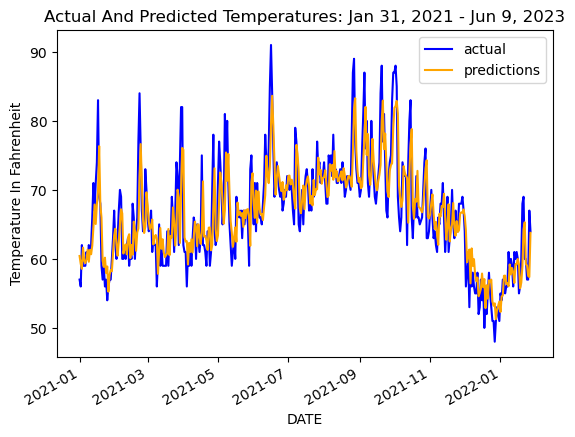

In [339]:
title = 'Actual and Predicted Temperatures: Jan 31, 2021 - Jun 9, 2023'.title()
ylabel = 'Temperature in Fahrenheit'.title()
colors = ['blue', 'orange']

combined.plot(title=title, ylabel=ylabel, color=colors)

The comparison chart looks similar to the one above.  Add in monthly and daily averages over all years as additional features.  More precisely, we will compute a rolling mean of the maximum temperature for each month and day over all years, respectively. 

In [340]:
core_weather['monthly_avg'] = core_weather['temp_max'].groupby(core_weather.index.month, group_keys=False).apply(lambda x: x.expanding(1).mean())
core_weather

,precip,temp_max,temp_min,target,month_max,month_day_max,max_min,monthly_avg
DATE,,,,,,,,
1960-01-31,0.00,59.0,46.0,62.0,55.566667,0.941808,1.282609,59.000000
1960-02-01,0.81,62.0,51.0,59.0,56.000000,0.903226,1.215686,62.000000
1960-02-02,0.00,59.0,43.0,59.0,56.166667,0.951977,1.372093,60.500000
1960-02-03,0.20,59.0,47.0,60.0,56.333333,0.954802,1.255319,60.000000
1960-02-04,0.16,60.0,42.0,60.0,56.500000,0.941667,1.428571,60.000000
...,...,...,...,...,...,...,...,...
2022-01-23,0.00,60.0,41.0,60.0,56.900000,0.948333,1.463415,56.781536
2022-01-24,0.00,60.0,39.0,57.0,57.066667,0.951111,1.538462,56.783803
2022-01-25,0.00,57.0,43.0,57.0,57.200000,1.003509,1.325581,56.783955


In [341]:
core_weather['day_of_year_avg'] = core_weather['temp_max'].groupby(core_weather.index.day_of_year, group_keys=False).apply(lambda x: x.expanding(1).mean())
core_weather

,precip,temp_max,temp_min,target,month_max,month_day_max,max_min,monthly_avg,day_of_year_avg
DATE,,,,,,,,,
1960-01-31,0.00,59.0,46.0,62.0,55.566667,0.941808,1.282609,59.000000,59.000000
1960-02-01,0.81,62.0,51.0,59.0,56.000000,0.903226,1.215686,62.000000,62.000000
1960-02-02,0.00,59.0,43.0,59.0,56.166667,0.951977,1.372093,60.500000,59.000000
1960-02-03,0.20,59.0,47.0,60.0,56.333333,0.954802,1.255319,60.000000,59.000000
1960-02-04,0.16,60.0,42.0,60.0,56.500000,0.941667,1.428571,60.000000,60.000000
...,...,...,...,...,...,...,...,...,...
2022-01-23,0.00,60.0,41.0,60.0,56.900000,0.948333,1.463415,56.781536,57.130435
2022-01-24,0.00,60.0,39.0,57.0,57.066667,0.951111,1.538462,56.783803,57.239130
2022-01-25,0.00,57.0,43.0,57.0,57.200000,1.003509,1.325581,56.783955,57.347826


In [342]:
predictors = ['precip', 'temp_max', 'temp_min', 'month_max', 'month_day_max', 'max_min', 'monthly_avg', 'day_of_year_avg']
error, combined = create_predictions(predictors, core_weather, reg)
error

3.3135532774970993

Our `error` was approx. 3.36 from our previous iteration.  It is approx. 3.31 now.  We are improving. 

In addition, the temperature on average over the ten day period was 52 degrees; the temperature for that day was 33 degrees, which is 19 degrees different.  In this case, it was just uncharacteristically cold that day.

## Add the temperature change rate `temp_max_ramp` as a new feature

In [343]:
core_weather['yesterday_temp_max'] = core_weather['temp_max'].shift(+1)
core_weather['temp_max_ramp'] = core_weather['temp_max'] - core_weather['yesterday_temp_max']
core_weather

,precip,temp_max,temp_min,target,month_max,month_day_max,max_min,monthly_avg,day_of_year_avg,yesterday_temp_max,temp_max_ramp
DATE,,,,,,,,,,,
1960-01-31,0.00,59.0,46.0,62.0,55.566667,0.941808,1.282609,59.000000,59.000000,NaN,NaN
1960-02-01,0.81,62.0,51.0,59.0,56.000000,0.903226,1.215686,62.000000,62.000000,59.0,3.0
1960-02-02,0.00,59.0,43.0,59.0,56.166667,0.951977,1.372093,60.500000,59.000000,62.0,-3.0
1960-02-03,0.20,59.0,47.0,60.0,56.333333,0.954802,1.255319,60.000000,59.000000,59.0,0.0
1960-02-04,0.16,60.0,42.0,60.0,56.500000,0.941667,1.428571,60.000000,60.000000,59.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-23,0.00,60.0,41.0,60.0,56.900000,0.948333,1.463415,56.781536,57.130435,69.0,-9.0
2022-01-24,0.00,60.0,39.0,57.0,57.066667,0.951111,1.538462,56.783803,57.239130,60.0,0.0
2022-01-25,0.00,57.0,43.0,57.0,57.200000,1.003509,1.325581,56.783955,57.347826,60.0,-3.0


In [344]:
df = core_weather.copy()

In [345]:
df = df.iloc[1 : ].copy()
df

,precip,temp_max,temp_min,target,month_max,month_day_max,max_min,monthly_avg,day_of_year_avg,yesterday_temp_max,temp_max_ramp
DATE,,,,,,,,,,,
1960-02-01,0.81,62.0,51.0,59.0,56.000000,0.903226,1.215686,62.000000,62.000000,59.0,3.0
1960-02-02,0.00,59.0,43.0,59.0,56.166667,0.951977,1.372093,60.500000,59.000000,62.0,-3.0
1960-02-03,0.20,59.0,47.0,60.0,56.333333,0.954802,1.255319,60.000000,59.000000,59.0,0.0
1960-02-04,0.16,60.0,42.0,60.0,56.500000,0.941667,1.428571,60.000000,60.000000,59.0,1.0
1960-02-05,0.67,60.0,53.0,63.0,56.733333,0.945556,1.132075,60.000000,60.000000,60.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2022-01-23,0.00,60.0,41.0,60.0,56.900000,0.948333,1.463415,56.781536,57.130435,69.0,-9.0
2022-01-24,0.00,60.0,39.0,57.0,57.066667,0.951111,1.538462,56.783803,57.239130,60.0,0.0
2022-01-25,0.00,57.0,43.0,57.0,57.200000,1.003509,1.325581,56.783955,57.347826,60.0,-3.0


In [346]:
predictors = ['precip', 'temp_max', 'temp_max_ramp', 'temp_min', 'month_max', 'month_day_max', 'max_min', 'monthly_avg', 'day_of_year_avg']
error, combined = create_predictions(predictors, df, reg)
error

3.2965375053251846

### With this new feature `temp_max_ramp', the error is further decreased from 3.314 to 3.297.

## Conclusion

We used a ridge regression model to predict the weather for the next day using historical data.  The predictions are for San Antonio, Texas, and the data came from The National Centers For Environmental Information (NCEI).  Using over 23,000 days of weather data, we were able to predict the maximum temperature.

# Save Model

In [49]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [347]:
import joblib


In [348]:
model_to_save = reg
file_name = 'weather_prediction_model.joblib'
joblib.dump(model_to_save, file_name)

['weather_prediction_model.joblib']